In [1]:
import numpy as np
import pandas as pd
from IPython.display import clear_output
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.animation import FuncAnimation

rc('font', size=16)

## Loading dataset

In [2]:
data_df = pd.read_csv('../raw_data/Air20Quality20Data/Beijing/CrawledData.txt')
data_df = data_df.dropna(subset=['PM25_AQI_value']) # Dropping null values on PM2.5

station_df = pd.read_csv('../raw_data/Air20Quality20Data/Beijing/Station.txt').set_index('station_id')
station_df = station_df.rename(columns={'longtitude':'longitude'}) # Small correction
print(data_df.shape)
data_df.head(2)

(167934, 10)


,station_id,time,PM25_AQI_value,PM10_AQI_value,NO2_AQI_value,temperature,pressure,humidity,wind,weather
0,1001,2/8/2013 9:00:00 PM,149.0,59.0,16.0,-5.0,1031.0,46.0,4.0,1.0
1,1001,2/8/2013 10:00:00 PM,159.0,65.0,22.0,-5.0,1030.0,46.0,1.0,1.0


In [3]:
station_df.head(2)

,station_name,latitude,longitude
station_id,,,
1001,haidianbeibuxinqu,40.09068,116.173553
1002,haidianbeijingzhiwuyuan,40.00395,116.205311


## Data sanity check

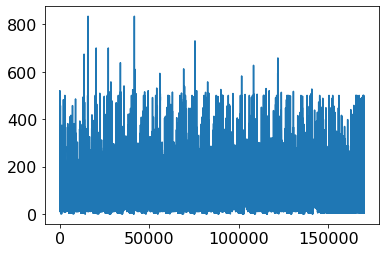

In [4]:
plt.plot(data_df.PM25_AQI_value); # No bad data visually
assert np.all(data_df.PM25_AQI_value >= 0) # PM25 can not be negative

## Sort by time-stamp

In [5]:
data_df['time'] = pd.to_datetime(data_df['time'])
data_df_sorted = data_df.set_index('time', drop=True).sort_index()
data_df_sorted.head(2)

,station_id,PM25_AQI_value,PM10_AQI_value,NO2_AQI_value,temperature,pressure,humidity,wind,weather
time,,,,,,,,,
2013-02-08 21:00:00,1001,149.0,59.0,16.0,-5.0,1031.0,46.0,4.0,1.0
2013-02-08 21:00:00,1021,184.0,87.0,48.0,-5.0,1031.0,46.0,4.0,1.0


In [6]:
data_df_sorted.tail(2)

,station_id,PM25_AQI_value,PM10_AQI_value,NO2_AQI_value,temperature,pressure,humidity,wind,weather
time,,,,,,,,,
2014-02-08 23:07:00,1017,8.0,6.0,9.0,-6.0,1031.0,29.0,11.16,2.0
2014-02-08 23:07:00,1036,8.0,11.0,10.0,-7.0,1029.0,41.0,20.88,2.0


## Combine station data with AQ+Met data

In [7]:
for new_col in ['station_name', 'longitude', 'latitude']:
    data_df_sorted[new_col] = data_df_sorted['station_id']
    data_df_sorted[new_col] = data_df_sorted[new_col].apply(lambda x: station_df.loc[x, new_col])

data_df_sorted.head(2)

,station_id,PM25_AQI_value,PM10_AQI_value,NO2_AQI_value,temperature,pressure,humidity,wind,weather,station_name,longitude,latitude
time,,,,,,,,,,,,
2013-02-08 21:00:00,1001,149.0,59.0,16.0,-5.0,1031.0,46.0,4.0,1.0,haidianbeibuxinqu,116.173553,40.090680
2013-02-08 21:00:00,1021,184.0,87.0,48.0,-5.0,1031.0,46.0,4.0,1.0,qianmendongdajie,116.395383,39.899136


## Plotting station locations

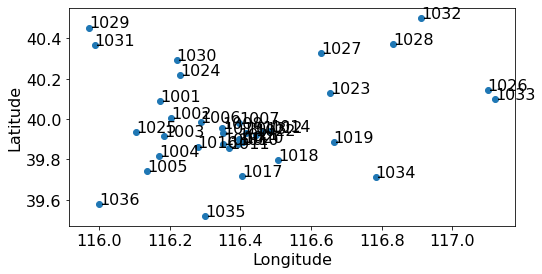

In [16]:
plt.figure(figsize=(8,4))
plt.scatter(station_df.longitude, station_df.latitude);
for i, x, y in zip(station_df.index, station_df.longitude, station_df.latitude):
    plt.text(x, y, i)
# print(station_df.head(2))
plt.xlabel('Longitude');plt.ylabel('Latitude');

## Checking info available per time-stamp

In [ ]:
count_df = pd.DataFrame(index=data_df_sorted.index.unique(), columns=['cnt'])
for idx in count_df.index:
    count_df.loc[idx, 'cnt'] = len(data_df_sorted.loc[idx])

plt.figure(figsize=(15,4))
plt.scatter(count_df.index, count_df.cnt);
plt.xlabel('time-frame');plt.ylabel('Number of stations');

## Finding longest contineous data with 36 stations

In [ ]:
station_c = pd.DataFrame(index=data_df_sorted.index.unique(), columns=['station_count'])
for idx in station_c.index:
    station_c.loc[idx, 'station_count'] = len(data_df_sorted.loc[idx])
station_c.head(2)

In [ ]:
delta = 24*20
for i in range(len(station_c)-delta):
    try:
        if station_c.iloc[i:i+delta]['station_count'].value_counts()[36] == delta:
            print('Best start index=', i)
            break
    except KeyError:
        pass

best_idx = station_c.index[i:i+delta]
plt.figure(figsize=(15,5))
plt.scatter(best_idx, np.ones(len(best_idx)));
plt.tight_layout();

#### Let us choose the first chunk of data from above plot.

In [ ]:
first_idx = station_c.index[i]
best_idxs = station_c[first_idx:'2013-11-25'].index
print("Number of time-stamps chosen =", best_idxs.shape)
best_idxs

## Saving processed dataset

In [ ]:
final_df = data_df_sorted.loc[best_idxs]
final_df.to_pickle('../processed_data/best36_beijing_pm25.pickle')
final_df.head(2)

### Visualize trend accross stations

In [ ]:
double_sorted_df = final_df.sort_values(['time','station_id'])
# print(double_sorted_df.head(5))
fig, ax = plt.subplots(figsize=(10,4))
def update(ts):
    ax.cla()
    tmp_df = double_sorted_df.loc[ts]
    ax.plot(tmp_df.PM25_AQI_value.values)
    ax.set_ylim(0,500)

plt.close()
anim = FuncAnimation(fig, update, double_sorted_df.index.unique())
rc('animation',html='jshtml',embed_limit=100)
anim